# Import

In [1]:
# -------------------------
# 0) CONFIG 
# -------------------------
import os, sys

# --- Env vars expected by csiro.config (no defaults) ---
COMP_ROOT = "/notebooks/kaggle/csiro"
TRAIN_CSV = f"{COMP_ROOT}/train.csv"
TEST_CSV = f"{COMP_ROOT}/test.csv"

IMAGE_ROOT = COMP_ROOT
sub_id = "3"
OUTPUT_PATH = f"/notebooks/kaggle/csiro/sub/sub{sub_id}.csv"
BB_TEST = COPY_WEIGHTS = WRITE_SUB = False

CSIRO_CODE_DIR = "/notebooks/CSIRO"
DINO_REPO = CSIRO_CODE_DIR + "/_dinov3"
sys.path.insert(0, CSIRO_CODE_DIR)
sys.path.insert(0, DINO_REPO)

os.environ["DEFAULT_DINO_ROOT"] = DINO_REPO
os.environ["DEFAULT_DATA_ROOT"] = COMP_ROOT
os.environ["DINO_B_WEIGHTS_PATH"] = "/notebooks/kaggle/csiro/weights/dinov3/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
os.environ["DINO_L_WEIGHTS_PATH"] = "/notebooks/kaggle/csiro/weights/dinov3/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"

# -------------------------
# 1) Imports
# -------------------------
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import shutil

import csiro
from csiro.config import TARGETS, dino_hub_name
from csiro.data import TiledSharedTTADataset, _maybe_preprocess_image
from csiro.eval import predict_ensemble_tiled, load_ensemble_states

# -------------------------
# 1) Params
# -------------------------
WEIGHTS_PATHS = [
    "/notebooks/kaggle/csiro/output/complete/CSIRO_v20_headDrop01.pt",
]

# Inference params
IMG_SIZE = 512
BATCH_SIZE = 16
NUM_WORKERS = 2
DEVICE = "cuda"  
MODEL_SIZE = "l"
DEFAULT_PLUS = ""
IMG_PREPROCESS = True

# TTA / ensemble knobs
TTA_N = 3
TTA_BCS = 0.1
TTA_HUE = 0.1
TTA_AGG = "mean"
INNER_AGG = "mean"
OUTER_AGG = "flatten"


if MODEL_SIZE == "b":
    DINO_WEIGHTS = os.getenv("DINO_B_WEIGHTS_PATH")
elif MODEL_SIZE == "l":
    DINO_WEIGHTS = os.getenv("DINO_L_WEIGHTS_PATH")
else:
    assert False

if COPY_WEIGHTS:
    src = DINO_WEIGHTS
    dst = f"/kaggle/working/{os.path.basename(DINO_WEIGHTS)}"
    shutil.copyfile(src, dst)
    DINO_WEIGHTS = dst


# Review transform

In [ ]:
from csiro.utils import preview_augments, build_color_jitter_sweep, load_train_dataset_simple
_, dataset = load_train_dataset_simple()

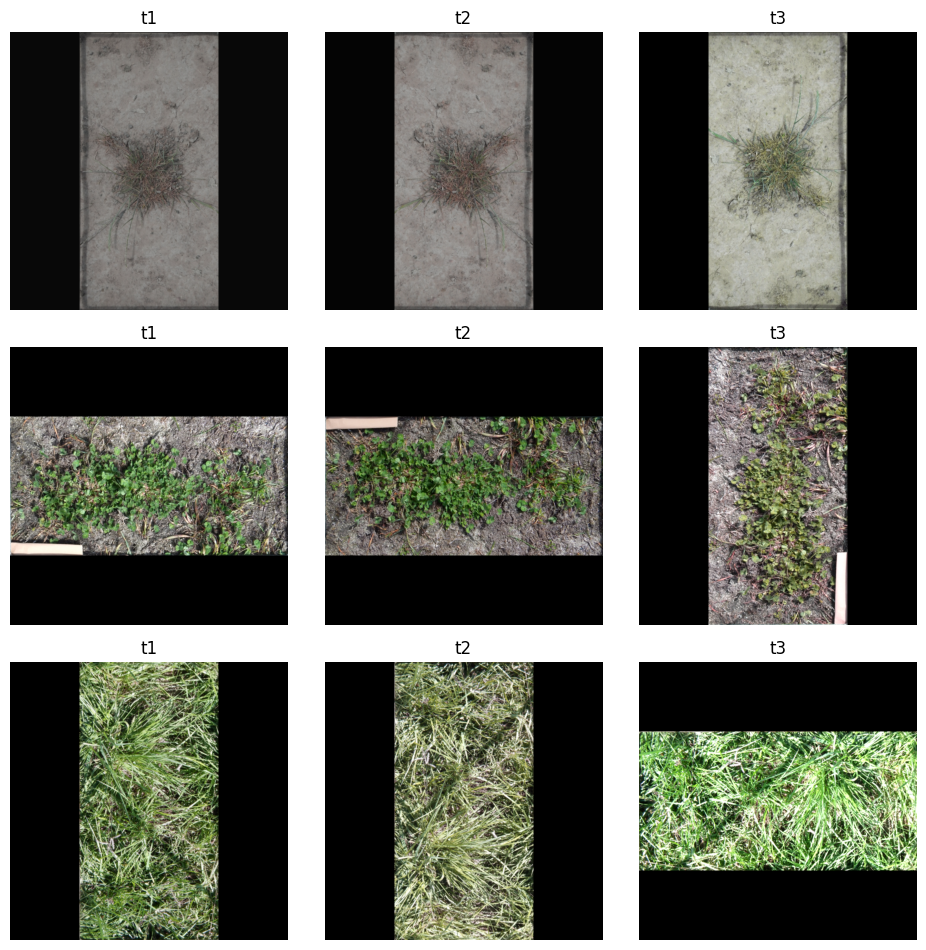

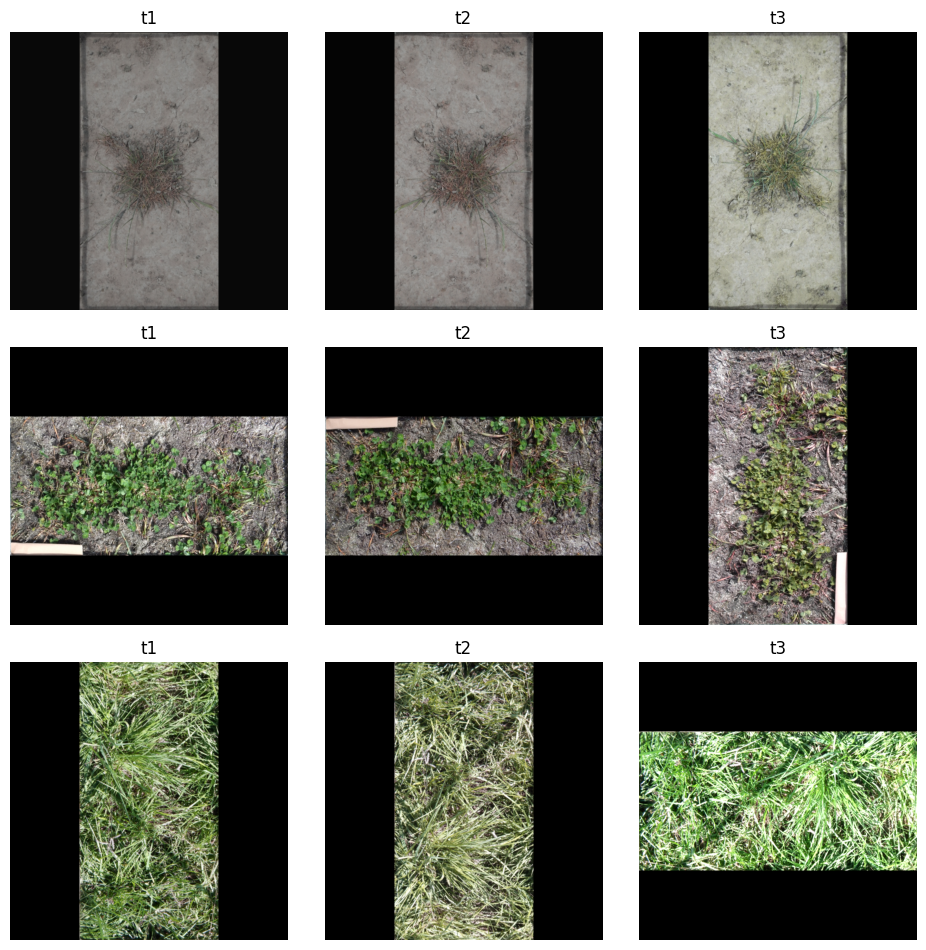

In [ ]:
from csiro.utils import build_color_jitter_sweep

# 3-point sweep around your default (0.25, 0.25, 0.25, 0.035)
tfms_list = build_color_jitter_sweep(
    3,
    bcs_range=(0.2, 0.35),
    hue_range=(0.035, 0.1),
)

preview_augments(
    tfms_list,
    dataset=dataset[1],
    k=3,
    seed=0,
    show_titles=True,
)

# Eval review

In [6]:
# -------------------------
# 2) Load checkpoint + backbone
# -------------------------
states = load_ensemble_states(WEIGHTS_PATHS)
backbone = torch.hub.load(
    DINO_REPO,
    dino_hub_name(model_size=MODEL_SIZE, plus=str(DEFAULT_PLUS)),
    source="local",
    weights=DINO_WEIGHTS,
).cuda()
backbone.eval()

# -------------------------
# 3) Read train.csv (wide_df)
# -------------------------
from csiro.data import load_train_wide

wide_df = load_train_wide(TRAIN_CSV, root=COMP_ROOT)
IMAGE_PATH_COL = "image_path"
TARGET_NAME_COL = "target_name"
SAMPLE_ID_COL = "sample_id"

# Build long df view for convenience (same shape as raw train.csv)
df = wide_df.copy()


#df_img = df.drop_duplicates(subset=[IMAGE_PATH_COL]).reset_index(drop=True)
#print("rows_long:", len(df), "unique_images:", len(df_img))



# test data

In [11]:
# -------------------------
# 4) Dataset + inference
# -------------------------
from csiro.data import BiomassFullCached, TiledSharedTransformView

# Labeled base dataset (returns PIL + y)
ds_base = BiomassFullCached(
    wide_df,
    cache_images=False,
    img_preprocess=IMG_PREPROCESS,
)

# Deterministic eval view (no TTA dimension)
ds = TiledSharedTransformView(
    ds_base,
    geom_tfms=None,
    img_size=IMG_SIZE,
)



In [21]:
# Eval: replay fold ensemble score
from csiro.eval import eval_fold_ensemble_from_pt

pt_path = "/notebooks/kaggle/csiro/output/states/CSIRO_v20_mixUp3_cv_state.pt"
# Example usage
results = eval_fold_ensemble_from_pt(
    pt_path=pt_path,
    fold_idx=1,
    dataset=ds,
    backbone=backbone,
    wide_df=df,
    cv_cfg=1,
    batch_size=BATCH_SIZE,
    inner_agg=INNER_AGG,
    tta_agg=TTA_AGG,
)
results


[{'run_idx': 0,
  'fold_idx': 1,
  'n_models': 3,
  'per_model_scores': [0.767898678779602,
   0.7492413520812988,
   0.7460243701934814],
  'ensemble_score': 0.7624850273132324}]